# Project Overview and Objectives

In this phase, we will convert our exploratory analysis into predictive modeling. The primary goal of this machine learning part is to determine if a player's on-court performance statistics (CPI) can reflect and accurately show their annual salary. Google Gemini is used here to detect our important key objectives and to find which sklearn methods should be best suitable to use for this phase. They will be wrapped up later.

### Key Objectives
- Create a supervised learning model to predict salaries.
- Detect the difference between ctual salaries and predicted pay.
- Use K-Means to cluster players into "Value Tiers"
- Evaluate moder performance using R-squared and Root Mean Squared Error (RMSE)

##### Data Sources

- Player statistics: Basketball Reference season totals
- Player salaries: Kaggle NBA salaries dataset

After loading both tables, I merge them by player name and keep only players that exist in both datasets.


We start off by loading the necessary data here. Since the values are stored as strings, we must strip and convert them to floating numbers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans

Data Cleaning and Feature Engineering

Steps applied before modeling:

- Strip player names.
- Convert numeric columns to numeric types and drop missing values where required.
- Remove duplicates in salary table.
- Filter out extreme low-minute samples to reduce noise (Minutes Played ≥ 500).
- Compute CPI = PTS + TRB + AST + STL + BLK − TOV  
- Compute VPD = (CPI / Salary) × 1000000

The resulting VPD is my interpretation, and is a metric I've created to determine the value per dollar per player. Analysis of the following aspects will be based on this data, which may or may not show the real picture in its entirety.


In [2]:
stats_df = pd.read_csv("data/player_statistics.csv")
stats_df['Player'] = stats_df['Player'].str.strip()
numeric_cols = ['Age', 'MP', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']
stats_df.dropna(subset = numeric_cols, inplace = True)
for col in numeric_cols:
    stats_df[col] = pd.to_numeric(stats_df[col])
stats_df.head()

,Rk,Player,Age,Pos,MP,TRB,AST,STL,BLK,TOV,PTS,Player-additional
0,1,Precious Achiuwa,25,C,1170,9.8,1.7,1.4,1.3,1.4,11.7,achiupr01
1,2,Steven Adams,31,C,794,14.8,3.0,1.0,1.3,2.4,10.2,adamsst01
2,3,Bam Adebayo,27,C,2674,10.1,4.5,1.3,0.7,2.2,19.0,adebaba01
3,4,Ochai Agbaji,24,SG,1739,5.0,2.0,1.2,0.6,1.1,13.8,agbajoc01
4,5,Santi Aldama,24,PF,1660,9.0,4.1,1.1,0.6,1.5,17.6,aldamsa01


In [3]:
salary_df = pd.read_csv("data/player_salaries.csv")
salary_df['Salary_USD'] = (salary_df['Salary'].astype(str).str.replace('$', '').str.replace(',', '').str.strip().astype(float))
salary_df.drop_duplicates(subset = ['Player'], keep = 'first', inplace = True) 
salary_df['Player'] = salary_df['Player'].str.strip()
salary_df.dropna(subset = ['Salary_USD'], inplace = True)
salary_df.head()

,Player,Team,Salary,Salary_USD
0,Stephen Curry,GSW,"$55,761,216",55761216.0
1,Joel Embiid,PHI,"$51,415,938",51415938.0
2,Nikola Jokic,DEN,"$51,415,938",51415938.0
3,Kevin Durant,PHO,"$51,179,021",51179021.0
4,Bradley Beal,PHO,"$50,203,930",50203930.0


Now to combine these datasets.

In [4]:
combined_df = pd.merge(stats_df, salary_df[['Player', 'Team', 'Salary_USD']])
combined_df['CPI'] = (combined_df['PTS'] + combined_df['TRB'] + combined_df['AST'] + combined_df['STL'] + combined_df['BLK'] - combined_df['TOV'])
combined_df['VPD'] = (combined_df['CPI'] / combined_df['Salary_USD']) * 1_000_000
df_clean = combined_df.copy()
df_clean = df_clean[(df_clean["MP"] >= 500) & (df_clean["Salary_USD"] > 0)].copy()
df_clean = df_clean[~df_clean["Salary_USD"].isna()]
df_clean.shape

df_clean.head()

,Rk,Player,Age,Pos,MP,TRB,AST,STL,BLK,TOV,PTS,Player-additional,Team,Salary_USD,CPI,VPD
0,1,Precious Achiuwa,25,C,1170,9.8,1.7,1.4,1.3,1.4,11.7,achiupr01,NYK,6000000.0,24.5,4.083333
1,2,Steven Adams,31,C,794,14.8,3.0,1.0,1.3,2.4,10.2,adamsst01,HOU,12600000.0,27.9,2.214286
2,3,Bam Adebayo,27,C,2674,10.1,4.5,1.3,0.7,2.2,19.0,adebaba01,MIA,34848340.0,33.4,0.958439
3,4,Ochai Agbaji,24,SG,1739,5.0,2.0,1.2,0.6,1.1,13.8,agbajoc01,TOR,4310280.0,21.5,4.988075
4,5,Santi Aldama,24,PF,1660,9.0,4.1,1.1,0.6,1.5,17.6,aldamsa01,MEM,3960531.0,30.9,7.801984


We know do a train/test split, so that the final evaluation is done on unseen players and is accurate, preventing the program to memorize the data.

We also built up our RMSE and R^2 functions to use them to compare two of our models later on.

In [5]:
feature_cols = ["CPI", "MP", "Age"]
target_col = "Salary_USD"

ml_df = df_clean.dropna(subset = feature_cols + [target_col]).copy()

X = ml_df[feature_cols].values
y = ml_df[target_col].values

print("Dataset size:", ml_df.shape)
print("Features:", feature_cols)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])

def rmse(y_true, y_pred):
    root_mean_squared_error = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return root_mean_squared_error

def r2_score_manual(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r_squared_score = 1 - (ss_res / ss_tot)
    return r_squared_score

Dataset size: (367, 16)
Features: ['CPI', 'MP', 'Age']
Train size: 293 Test size: 74


Model 1: Linear Regression

We will now be using linear regression to show the baseline of our data. Linear regression will be used here because it is a simple way to start out.

I wtill also clearly show our coefficients against the predicted and actual salaries. The performance will be evaluated using RSME and R^2.


RMSE: 10478673.543863138
R^2 : 0.5588046876185153


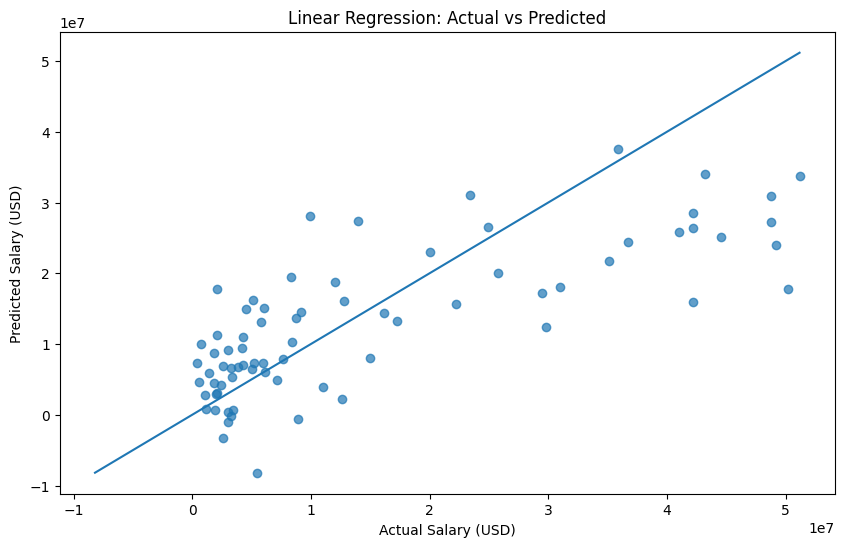

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linear_regression = LinearRegression()
linear_regression.fit(X_train_scaled, y_train)

y_predicted_linear_rregression = linear_regression.predict(X_test_scaled)

lr_rmse = rmse(y_test, y_predicted_linear_rregression)
lr_r2 = r2_score_manual(y_test, y_predicted_linear_rregression)

print("RMSE:", lr_rmse)
print("R^2 :", lr_r2)

plt.figure(figsize = (10, 6))
plt.scatter(y_test, y_predicted_linear_rregression, alpha = 0.7)
minv = min(y_test.min(), y_predicted_linear_rregression.min())
maxv = max(y_test.max(), y_predicted_linear_rregression.max())
plt.plot([minv, maxv], [minv, maxv])
plt.xlabel("Actual Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.title("Linear Regression: Actual vs Predicted")
plt.show()

Model 2: Decision Tree Regressor

A decision tree regression model will be used to capture non-linear relationships. We will be using the same metrics of RMSE and R^2 to compare it with our linear regression model.

RMSE: 13081634.275825888
R^2 : 0.3123898553840455


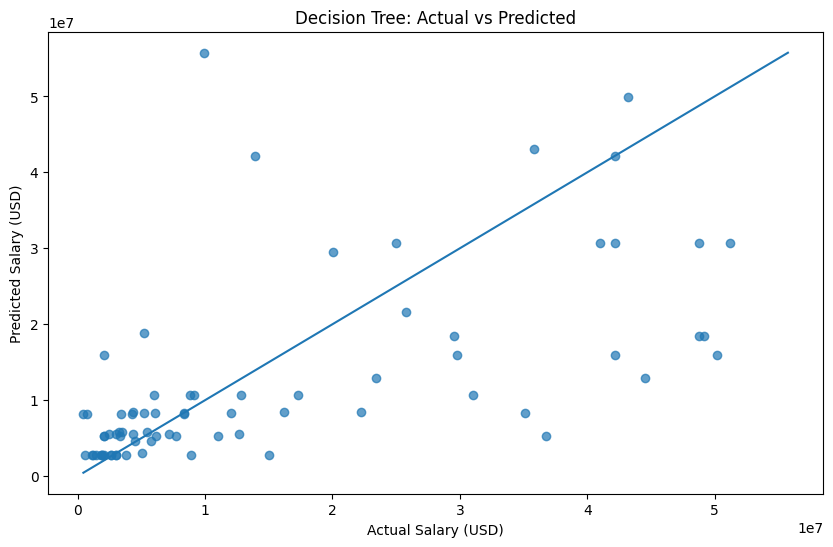

In [7]:
tree_regression = DecisionTreeRegressor(random_state = 42, max_depth = 5)
tree_regression.fit(X_train, y_train)

y_predicted_tree = tree_regression.predict(X_test)

tree_rmse = rmse(y_test, y_predicted_tree)
tree_r2 = r2_score_manual(y_test, y_predicted_tree)
print("RMSE:", tree_rmse)
print("R^2 :", tree_r2)

plt.figure(figsize = (10, 6))
plt.scatter(y_test, y_predicted_tree, alpha = 0.7)
minv = min(y_test.min(), y_predicted_tree.min())
maxv = max(y_test.max(), y_predicted_tree.max())
plt.plot([minv, maxv], [minv, maxv])
plt.xlabel("Actual Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.title("Decision Tree: Actual vs Predicted")
plt.show()

Now we compare our Linear Regression model and our Decision Tree Regression model.
- R^2 must be higher,
- RMSE must be lower

This will give us an idea of whether simple linear relationships are sufficient to predict the salary indifferences in our study, or is it better to use non-linear metrics.

In [8]:
results = pd.DataFrame({"Model": ["Linear Regression", "Decision Tree"], "RMSE": [lr_rmse, tree_rmse], "R2": [lr_r2, tree_r2]}).sort_values("RMSE")

results


,Model,RMSE,R2
0,Linear Regression,1.047867e+07,0.558805
1,Decision Tree,1.308163e+07,0.312390


As we can see in out dataframe above, linear regression has both the higher R^2 and the lower RMSE. We will now be listing the predicted salaries and actual pays of the basketball players and get a deeper look into top 10 players of each side. 

We will still be implementing this using both Linear Regression and Decision Tree models, but will only be using the favorible option.

I will compute the predicted salary for each player, and then its difference between actual pay (Actual Pay - Predicted Salary) by doing this, we will be getting the change factor.

Change factor difference will show how much a player needs to earn more/less. If it is positive, the player must earn more equal to that amount. If it is negative, the player must learn less equal to that value.

In [9]:
best_model_name = results.iloc[0]["Model"]
print("Best model by RMSE:", best_model_name)

if best_model_name == "Linear Regression":
    scaler_full = StandardScaler()
    X_full_scaled = scaler_full.fit_transform(X)
    best_model = LinearRegression()
    best_model.fit(X_full_scaled, y)
    y_predicted_full = best_model.predict(X_full_scaled)
else:
    best_model = DecisionTreeRegressor(random_state = 42, max_depth = 5)
    best_model.fit(X, y)
    y_predicted_full = best_model.predict(X)

ml_df["Predicted_Salary_USD"] = y_predicted_full
ml_df["Change_Factor_Difference"] = ml_df["Salary_USD"] - ml_df["Predicted_Salary_USD"]

top_underpaid = ml_df.sort_values("Change_Factor_Difference", ascending = False).head(10)[["Player", "Team", "Pos", "CPI", "Salary_USD", "Predicted_Salary_USD", "Change_Factor_Difference"]]

top_overpaid = ml_df.sort_values("Change_Factor_Difference", ascending = True).head(10)[["Player", "Team", "Pos", "CPI", "Salary_USD", "Predicted_Salary_USD", "Change_Factor_Difference"]]

Best model by RMSE: Linear Regression


Now we take a good look at underpaid players, who perform better and deserve a higher pay than what they get.

In [10]:
print("Top 10 Underpaid Players:")
top_underpaid

Top 10 Underpaid Players:


,Player,Team,Pos,CPI,Salary_USD,Predicted_Salary_USD,Change_Factor_Difference
31,Bradley Beal,PHO,SG,26.6,50203930.0,1.883897e+07,3.136496e+07
400,Ben Simmons,BRK,PG,23.7,40011909.0,9.504943e+06,3.050697e+07
145,Paul George,PHI,PF,28.2,49205800.0,2.134585e+07,2.785995e+07
128,Joel Embiid,PHI,C,41.4,51415938.0,2.561640e+07,2.579953e+07
272,Lauri Markkanen,UTA,PF,29.9,42176400.0,1.659317e+07,2.558323e+07
442,Fred VanVleet,HOU,PG,24.4,42846615.0,1.805617e+07,2.479044e+07
52,Jaylen Brown,BOS,SF,33.0,49205800.0,2.463889e+07,2.456691e+07
256,Kawhi Leonard,LAC,SF,34.6,49205800.0,2.564350e+07,2.356230e+07
198,Brandon Ingram,TOR,SF,33.4,36016200.0,1.484495e+07,2.117125e+07
40,Devin Booker,PHO,SG,33.8,49205800.0,2.914685e+07,2.005895e+07


Now let's see some players who earn more than they are supposed to according to our study

In [11]:
print("Top 10 OVERPAID (Paid > Predicted):")
top_overpaid

Top 10 OVERPAID (Paid > Predicted):


,Player,Team,Pos,CPI,Salary_USD,Predicted_Salary_USD,Change_Factor_Difference
463,Russell Westbrook,DEN,PG,29.6,5631296.0,2.921495e+07,-2.358365e+07
440,Jonas Valanciunas,SAC,C,37.8,9900000.0,2.973960e+07,-1.983960e+07
389,Alperen Sengun,HOU,C,38.5,5424654.0,2.517759e+07,-1.975293e+07
336,Chris Paul,SAS,PG,25.4,10460000.0,2.939775e+07,-1.893775e+07
229,DeAndre Jordan,DEN,C,28.6,2087519.0,2.003999e+07,-1.795247e+07
473,Jalen Williams,OKC,SG,35.7,4775760.0,2.255985e+07,-1.778409e+07
488,Ivica Zubac,LAC,C,35.5,11743210.0,2.876737e+07,-1.702416e+07
343,Mason Plumlee,PHO,C,26.1,2087519.0,1.910151e+07,-1.701399e+07
111,Spencer Dinwiddie,DAL,PG,23.9,2087519.0,1.874977e+07,-1.666225e+07
212,Ty Jerome,CLE,SG,33.0,2560975.0,1.912074e+07,-1.655977e+07


Let's also take a peek at some other players I've selected from my head that are not in one of these lists.

In [15]:
targets = ["Alperen Sengun", "LeBron James", "Kyrie Irving", "Stephen Curry", "James Harden", "Adem Bona"]

ml_df.loc[ml_df["Player"].isin(targets), ["Player", "Team", "Pos", "CPI", "Salary_USD", "Predicted_Salary_USD", "Change_Factor_Difference"]]


,Player,Team,Pos,CPI,Salary_USD,Predicted_Salary_USD,Change_Factor_Difference
39,Adem Bona,PHI,C,25.5,1157153.0,2.759896e+06,-1.602743e+06
98,Stephen Curry,GSW,PG,37.8,55761216.0,3.813801e+07,1.762320e+07
166,James Harden,LAC,PG,35.9,33653846.0,3.839668e+07,-4.742830e+06
199,Kyrie Irving,DAL,SG,33.6,41000000.0,2.728800e+07,1.371200e+07
209,LeBron James,LAL,SF,39.5,48728845.0,4.505458e+07,3.674260e+06
389,Alperen Sengun,HOU,C,38.5,5424654.0,2.517759e+07,-1.975293e+07


Finally, I decided to apply K-Means to our data to assign our players into "Value Tiers". This will help us group players and give us a broader definition on how they can be grouped such as:

- High salary and high CPI,
- High salary and low CPI...

And such to standardize their features.

(This part will be upgraded)


In [16]:
cluster_features = ml_df[["CPI", "Salary_USD"]].values

scaler_km = StandardScaler()
cluster_scaled = scaler_km.fit_transform(cluster_features)

k = 3
k_means = KMeans(n_clusters = k, random_state = 42, n_init = 10)
ml_df["Tier"] = k_means.fit_predict(cluster_scaled)

tier_summary = ml_df.groupby("Tier").agg(count = ("Player", "count"),avg_CPI = ("CPI", "mean"),avg_salary = ("Salary_USD", "mean"),average_change_factor = ("Change_Factor_Difference", "mean")).sort_values("avg_salary")

tier_summary

,count,avg_CPI,avg_salary,average_change_factor
Tier,,,,
1,175,21.778286,6.427268e+06,-2.514014e+05
0,133,30.175188,1.037790e+07,-5.439857e+06
2,59,34.855932,3.882634e+07,1.300841e+07


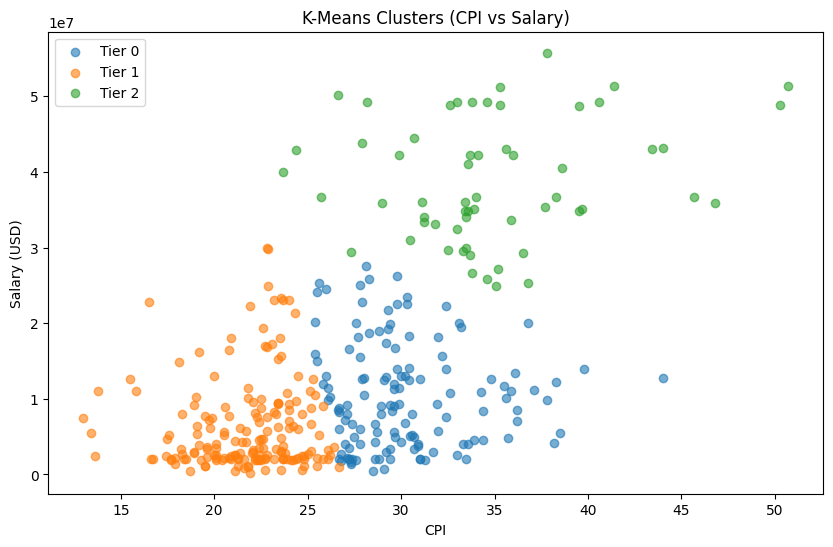

In [17]:
plt.figure(figsize = (10, 6))
for tier_id in sorted(ml_df["Tier"].unique()):
    tiers = ml_df[ml_df["Tier"] == tier_id]
    plt.scatter(tiers["CPI"], tiers["Salary_USD"], alpha = 0.6, label = f"Tier {tier_id}")

plt.xlabel("CPI")
plt.ylabel("Salary (USD)")
plt.title("K-Means Clusters (CPI vs Salary)")
plt.legend()
plt.show()